In [59]:
%pylab inline
import emcee
import programas as pg
import h5py
import MAS_library as MASL
import smoothing_library as SL
import Pk_library as PKL

Populating the interactive namespace from numpy and matplotlib


/home/arodriguez/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes', 'figure', 'ndim', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# bias parameters por P(K)

## El modelo depende de cross power spectrum:

$P(K) = \sum_{i,j \in [1, \delta, \delta^2, s^2, \nabla^2\delta]} b_i·b_j·<|\delta_i(k)·\delta_j(k)| > + \frac{A_{sn}}{\hat{n}}$ 

donde tengo entonces 5 parametros: ($b_1, b_2, b_{s^{2}}, b_{\nabla^2}, A_{sn}$)

In [60]:
# Función de verosimilitud
def log_likelihood(params, P_obs, P00, P01, P02, P03, P04, P11, P12, P13, P14, P22, P23, P24, P33, P34, P44, n,  C_inv):
    b1, b2, b3,b4, A = params
    b0 = 1
    model = (b0*b0*P00 + b0*b1*P01 + b0*b2*P02 + b0*b3*P03 + b0*b4*P04+
           b1*b0*P01 + b1*b1*P11 + b1*b2*P12 + b1*b3*P13 + b1*b4*P14 +
           b2*b0*P02 + b2*b1*P12 + b2*b2*P22 + b2*b3*P23 + b2*b4*P24 +
           b3*b0*P03 + b3*b1*P13 + b3*b2*P23 + b3*b3*P33 + b3*b4*P34 +
           b4*b0*P04 + b4*b1*P14 + b4*b2*P24 + b4*b3*P34 + b4*b4*P44) + A/n
    
    diff = P_obs - model
    return -0.5 * np.dot(diff, np.dot(C_inv, diff))

# Priors
def log_prior(params):
    b1, b2, b3, b4, A = params
    if -20 < b1 < 20 and -20 < b2 < 20 and -20 < b3 < 20 and -50 < b4 < 50 and 0 < A < 2:  # Rango de ejemplo
        return 0.0
    return -np.inf

# Función posterior
def log_posterior(params, P_obs, P00, P01, P02, P03, P04, P11, P12, P13, P14, P22, P23, P24, P33, P34, P44, n, C_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, P_obs, P00, P01, P02, P03, P04, P11, P12, P13, P14, P22, P23, P24, P33, P34, P44, n, C_inv)

In [124]:
R_sm = 12

path = '/home/arodriguez/BACCO/bias-voids/IATE/PowerSpectrum/'
k_full   = np.load(path+'k_'+str(R_sm)+'.npy')
P00_full = np.load(path+'P00_'+str(R_sm)+'.npy')
P01_full = np.load(path+'P01_'+str(R_sm)+'.npy')
P02_full = np.load(path+'P02_'+str(R_sm)+'.npy')
P03_full = np.load(path+'P03_'+str(R_sm)+'.npy')
P04_full = np.load(path+'P04_'+str(R_sm)+'.npy')
P11_full = np.load(path+'P11_'+str(R_sm)+'.npy')
P12_full = np.load(path+'P12_'+str(R_sm)+'.npy')
P13_full = np.load(path+'P13_'+str(R_sm)+'.npy')
P14_full = np.load(path+'P14_'+str(R_sm)+'.npy')
P22_full = np.load(path+'P22_'+str(R_sm)+'.npy')
P23_full = np.load(path+'P23_'+str(R_sm)+'.npy')
P24_full = np.load(path+'P24_'+str(R_sm)+'.npy')
P33_full = np.load(path+'P33_'+str(R_sm)+'.npy')
P34_full = np.load(path+'P34_'+str(R_sm)+'.npy')
P44_full = np.load(path+'P44_'+str(R_sm)+'.npy')

P_obs_full = np.load(path+'Psimu_'+str(R_sm)+'.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/home/arodriguez/BACCO/bias-voids/IATE/PowerSpectrum/k_12.npy'

In [125]:
sel, = np.where( k_full < 0.7 )
npower = len(sel)
print('dim:',npower)

P00 = P00_full[sel]
P01 = P01_full[sel]
P02 = P02_full[sel]
P03 = P03_full[sel]
P04 = P04_full[sel]
P11 = P11_full[sel]
P12 = P12_full[sel]
P13 = P13_full[sel]
P14 = P14_full[sel]
P22 = P22_full[sel]
P23 = P23_full[sel]
P24 = P24_full[sel]
P33 = P33_full[sel]
P34 = P34_full[sel]
P44 = P44_full[sel]
P_obs = P_obs_full[sel]
k = k_full[sel]

dim: 159


In [7]:
C = np.eye(npower)
C_inv = np.linalg.inv(C)

# Voy a usar el metodo de aproximacion gauseana para estimar la covariance matrix 

_ Pgg(k)
_ P_noise(k): shot noise
_ N_k : numero de modos por bin en k
_ volumen

entonces:

$Cov(P(k),P(k))= 2/N_k · (P_{tot}(k))^2$

con

$P_{tot} = P_{gg} + P_{noise}$

In [122]:
V = 1440**3
shot_noise = 1/5e-04
delta_k = k[1]-k[0]
P_noise = shot_noise
P_tot = P_obs + P_noise

# Número de modos independientes (N_k)
N_k = V * (k**2) * delta_k / (2 * np.pi**2)

# Matriz de covarianza diagonal
covariance_diag = 2 * (P_tot**2) / N_k
covariance_matrix = np.diag(covariance_diag)
C_inv = np.linalg.inv(covariance_matrix)

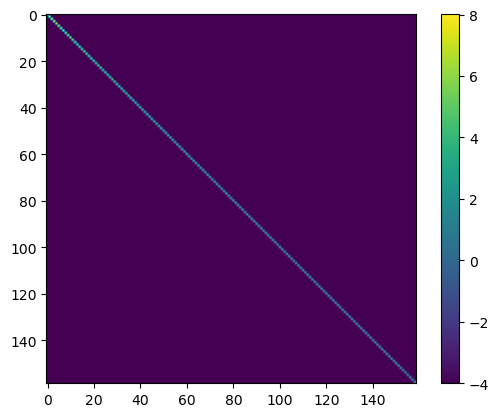

In [123]:
covariance_matrix = np.diag(covariance_diag)
C_inv = np.linalg.inv(covariance_matrix)
plt.imshow(np.log10(covariance_matrix+1e-00004))
plt.colorbar()

In [116]:
n = 5e-04

In [117]:
# Configuración de MCMC
ndim = 5  # Número de parámetros
nwalkers = 50  # Número de walkers
nsteps = 5000  # Número de pasos

# Inicializar walkers aleatoriamente
starting_guesses = np.random.rand(nwalkers, ndim)

# Ejecutar MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(P_obs, P00, P01, P02, P03, P04, P11, P12, P13, P14, 
                                                                     P22, P23, P24, P33, P34, P44, n, C_inv))
_ = sampler.run_mcmc(starting_guesses, nsteps, progress=True)

# Análisis de resultados
samples = sampler.get_chain(discard=2000, thin=10, flat=True)  # Descartar los primeros 100 pasos (burn-in)
b1_samples, b2_samples, b3_samples, b4_samples, A_samples = samples[:, 0], samples[:, 1], samples[:,2], samples[:,3], samples[:,4]

100%|██████████████████████████████████████████████████████████| 5000/5000 [00:34<00:00, 145.56it/s]


In [118]:
b1_mean, b1_std = np.mean(b1_samples), np.std(b1_samples)
b2_mean, b2_std = np.mean(b2_samples), np.std(b2_samples)
b3_mean, b3_std = np.mean(b3_samples), np.std(b3_samples)
b4_mean, b4_std = np.mean(b4_samples), np.std(b4_samples)
A_mean, A_std   = np.mean(A_samples), np.std(A_samples)

In [119]:
b0 = 1
b1 = b1_mean
b2 = b2_mean
b3 = b3_mean
b4 = b4_mean
A  = A_mean
model = (b0*b0*P00 + b0*b1*P01 + b0*b2*P02 + b0*b3*P03 + b0*b4*P04+
           b1*b0*P01 + b1*b1*P11 + b1*b2*P12 + b1*b3*P13 + b1*b4*P14 +
           b2*b0*P02 + b2*b1*P12 + b2*b2*P22 + b2*b3*P23 + b2*b4*P24 +
           b3*b0*P03 + b3*b1*P13 + b3*b2*P23 + b3*b3*P33 + b3*b4*P34 +
           b4*b0*P04 + b4*b1*P14 + b4*b2*P24 + b4*b3*P34 + b4*b4*P44) + A/n

Text(0.5, 0, '$ k$')

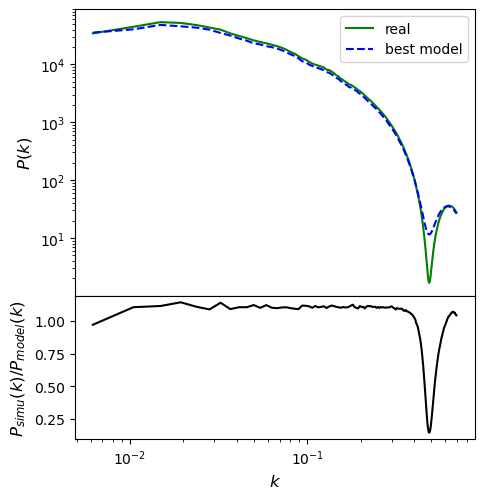

In [120]:
fig, ax = plt.subplots(ncols=1,nrows=2,figsize=(5,5),sharey='row'
                       ,gridspec_kw={'height_ratios': [2, 1]})
fig.subplots_adjust(hspace=(0.00),wspace=(.28),bottom=0.12, top=0.98, left=0.17, right=0.97)


ax[0].plot(k, P_obs, label='real', color='green')
ax[0].plot(k, model, ls='dashed', label='best model', color='blue')
ax[0].semilogy()
ax[0].semilogx()
#ax[0].plot(dist, F_model_j, ls='dotted', label='jens model', color='black')
ax[0].legend()
#plt.ylim(-1.4,0.2)

ax[0].set_ylabel('$ P(k) $',size=12)

ax[1].plot(k, P_obs/model, color='black')
ax[1].set_ylabel('$ P_{simu}(k)/P_{model}(k) $',size=12)
#ax[1].set_ylabel('$\\frac{\\delta_m-\\delta_{obs}}{\\sigma}$',size=12)
ax[1].semilogx()
ax[1].set_xlabel('$ k$',size=12)

In [57]:
b4_samples

array([9.4782264 , 9.47837676, 9.47876677, ..., 9.47790987, 9.4776856 ,
       9.47818927])

BACCO: 0.8952928842732011 0.4808350360033147 -8.03005463260268 2.3375036888906173 0.0050313974910337735


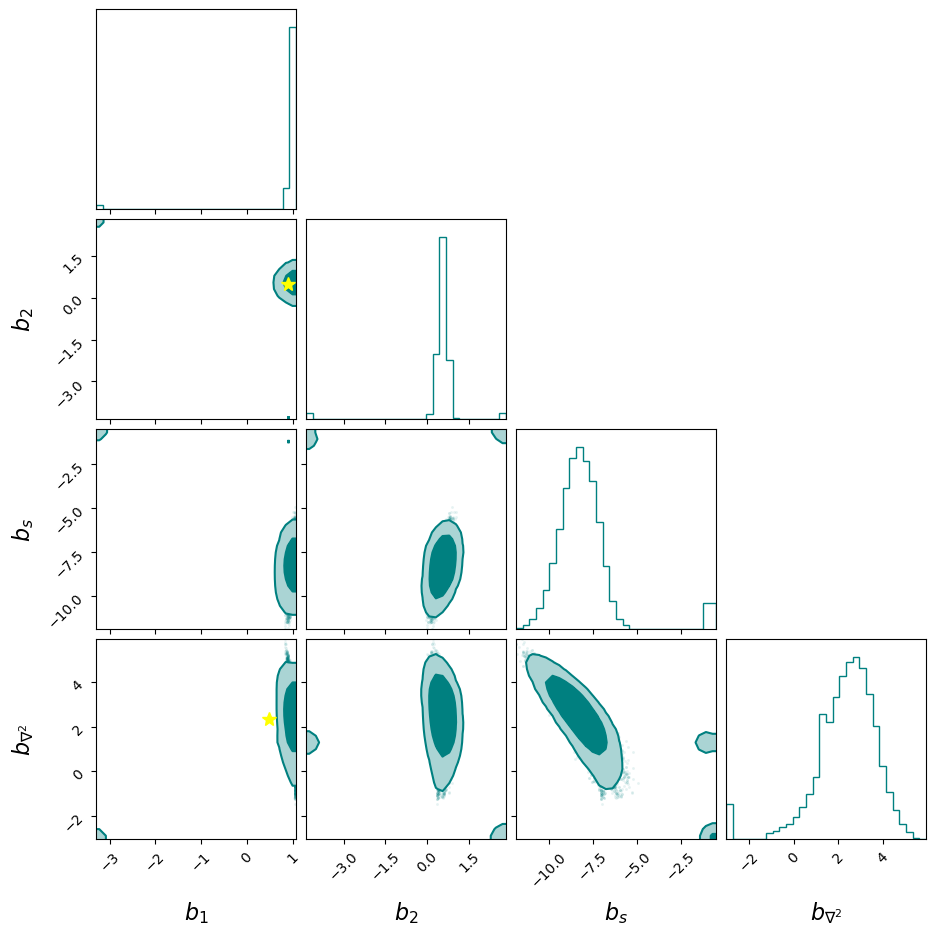

In [121]:
import corner
import random


#seleccion = random.sample(list(np.arange(0,len(b1_samples))),30000)
# Crear el gráfico de corner con tres parámetros
figure = corner.corner(np.vstack([b1_samples, b2_samples, b3_samples ,b4_samples]).T,
                       labels=["$ b_1 $", "$b_2$", "$b_s$","$ b_{\\nabla^2} $"],
                       bins=30, smooth=1.0, plot_datapoints=True,
                       plot_contours=True, fill_contours=True,
                       levels=[0.68, 0.95],
                       label_kwargs={"fontsize": 16},
                       color='teal')

# Obtener los ejes del corner plot
axes = figure.axes
# Agregar la estrellita en el panel correspondiente a (b1, b2)
#axes[4].plot(b1_jens, b2_jens, marker='*', color='red', markersize=10)
axes[4].plot(b1_mean, b2_mean, marker='*', color='yellow', markersize=10)
# Agregar la estrellita en el panel correspondiente a (b1, b4)
#axes[8].plot(b1_jens, b4_jens, marker='*', color='red', markersize=10)
axes[8].plot(b1_mean, b4_mean, marker='*', color='yellow', markersize=10)
# Agregar la estrellita en el panel correspondiente a (b2, b4)
#axes[12].plot(b2_jens, b4_jens, marker='*', color='red', markersize=10)
axes[12].plot(b2_mean, b4_mean, marker='*', color='yellow', markersize=10)

#print('BACCO:',b1_jens, b2_jens, b4_jens)
print('BACCO:',b1_mean, b2_mean, b3_mean, b4_mean, A_mean)